In [9]:
import pandas as pd
from NEExT.io import GraphIO
import igraph as ig
from matplotlib import pyplot as plt
import numpy as np

from NEExT.collections.egonet_collection import EgonetCollection
from NEExT.features.structural_node_features import StructuralNodeFeatures
from NEExT.features.node_features import NodeFeatures
from NEExT.builders.embedding_builder import EmbeddingBuilder
import seaborn as sns

%reload_ext autoreload
%autoreload 2

In [10]:
edges_df = pd.read_csv("data/barbell", delimiter=" ", header=None)
edges_df.columns = ["src_node_id", "dest_node_id"]

nodes = list(set(edges_df["src_node_id"].unique().tolist() + edges_df["dest_node_id"].unique().tolist()))
features_df = pd.DataFrame()
features_df["node_id"] = nodes
# for this problem as an outlier we define nodes that form clusters at the edges of a chain
features_df["is_outlier"] = np.where(np.array(ig.Graph(edges_df.values).degree())> 2, 1, 0)

mapping_df = pd.DataFrame()
mapping_df["node_id"] = nodes
mapping_df["graph_id"] = 0

graph_io = GraphIO()
graph_collection = graph_io.load_from_dfs(
    edges_df=edges_df,
    node_graph_df=mapping_df,
    node_features_df=features_df,
    graph_type="igraph",
    filter_largest_component=False,
)

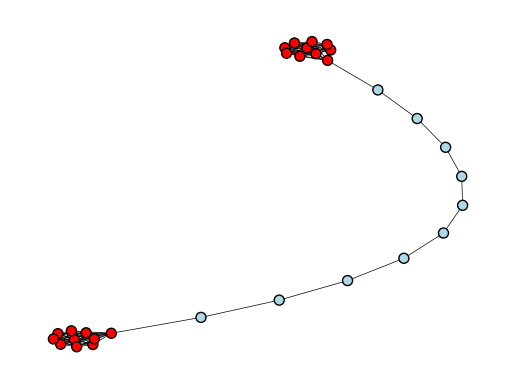

In [11]:
graph = graph_collection.graphs[0].G

node_colors = ["red" if node["is_outlier"] else "lightblue" for node in graph.vs]
edge_colors = ["black" for _ in graph.es]
layout = graph.layout("fr")

visual_style = {}
visual_style["vertex_size"] = 10
visual_style["vertex_color"] = node_colors
visual_style["edge_color"] = edge_colors
visual_style["edge_width"] = 0.5
visual_style["layout"] = layout
visual_style["vertex_label"] = None
visual_style["bbox"] = (600, 600)
visual_style["margin"] = 20


fig, ax = plt.subplots()
ig.plot(graph, target=ax, **visual_style)
plt.show()

In [16]:
# labeling if the nodes has an outlier in its k-hop neighborhood
k_hop = 1

outlier_in_neighborhood = []

outlier_nodes = features_df.query("is_outlier == 1")["node_id"].tolist()
for node in range(graph.vcount()):
    neighbors = list(i for i in graph.neighborhood(node, order=k_hop) if i != node)
    if any(n in outlier_nodes for n in neighbors):
        outlier_in_neighborhood.append(1)
    elif node in outlier_nodes:
        outlier_in_neighborhood.append(2)
    else:
        outlier_in_neighborhood.append(0)
    print(node, neighbors, outlier_in_neighborhood[-1])

0 [1, 2, 3, 4, 5, 6, 7, 8, 9] 1
1 [0, 2, 3, 4, 5, 6, 7, 8, 9] 1
2 [0, 1, 3, 4, 5, 6, 7, 8, 9] 1
3 [0, 1, 2, 4, 5, 6, 7, 8, 9] 1
4 [0, 1, 2, 3, 5, 6, 7, 8, 9] 1
5 [0, 1, 2, 3, 4, 6, 7, 8, 9] 1
6 [0, 1, 2, 3, 4, 5, 7, 8, 9] 1
7 [0, 1, 2, 3, 4, 5, 6, 8, 9] 1
8 [0, 1, 2, 3, 4, 5, 6, 7, 9] 1
9 [0, 1, 2, 3, 4, 5, 6, 7, 8, 10] 1
10 [9, 11] 1
11 [10, 12] 0
12 [11, 13] 0
13 [12, 14] 0
14 [13, 15] 0
15 [14, 16] 0
16 [15, 17] 0
17 [16, 18] 0
18 [17, 19] 0
19 [18, 20] 1
20 [19, 21, 22, 23, 24, 25, 26, 27, 28, 29] 1
21 [20, 22, 23, 24, 25, 26, 27, 28, 29] 1
22 [20, 21, 23, 24, 25, 26, 27, 28, 29] 1
23 [20, 21, 22, 24, 25, 26, 27, 28, 29] 1
24 [20, 21, 22, 23, 25, 26, 27, 28, 29] 1
25 [20, 21, 22, 23, 24, 26, 27, 28, 29] 1
26 [20, 21, 22, 23, 24, 25, 27, 28, 29] 1
27 [20, 21, 22, 23, 24, 25, 26, 28, 29] 1
28 [20, 21, 22, 23, 24, 25, 26, 27, 29] 1
29 [20, 21, 22, 23, 24, 25, 26, 27, 28] 1


In [59]:
# list(graph.bfsiter(0))
list(graph.bfsiter(0, advanced=True))[3][0].index

3

In [60]:
global_structural_node_features = StructuralNodeFeatures(
    graph_collection=graph_collection,
    suffix="global",
    feature_list=['page_rank'],
    feature_vector_length=2,
    n_jobs=1,
).compute()
# adding global node features as an information for local embedding
graph_collection.add_node_features(global_structural_node_features.features_df)

egonet_collection = EgonetCollection(skip_features=["is_outlier"])
egonet_collection.compute_k_hop_egonets(graph_collection, k_hop, nodes_to_sample={0:[0, 10]},sample_fraction=1)
egonet_sampled_nodes = [graph.original_node_id for graph in egonet_collection.graphs]
################################
node_features = NodeFeatures(
    egonet_collection,
    feature_list=global_structural_node_features.feature_columns,
    n_jobs=1,
)
global_features = node_features.compute()
############################
emb_builder = EmbeddingBuilder(
    graph_collection=egonet_collection,
    # structural_features=structural_features,
    features=global_features,
    embeddings_dimension=2,
)
embeddings = emb_builder.compute("feature_embeddings")

Computing structural node features:   0%|          | 0/1 [00:00<?, ?it/s]

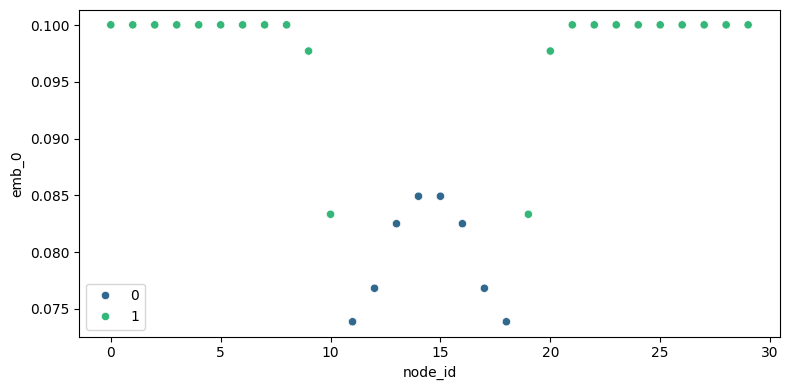

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.scatterplot(
    x=embeddings.embeddings_df.iloc[:, 0],
    y=embeddings.embeddings_df.iloc[:, 1],
    # hue=features_df['is_outlier'],
    hue=np.array(outlier_in_neighborhood)[egonet_sampled_nodes],
    ax=ax,
    palette='viridis',
)
ax.set_xlabel("node_id")
ax.set_ylabel("emb_0")
fig.tight_layout()

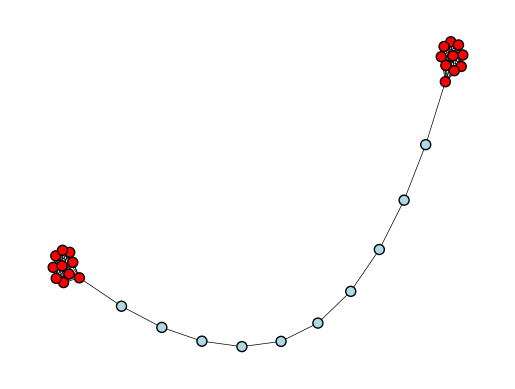

In [8]:
fig, ax = plt.subplots()
ig.plot(graph, target=ax, **visual_style)
plt.show()